<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/2PTQMOMBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


CALIBRATED PARAMETERS (two-interval)
Window 0-150: J1=17.012 #/cm3/s, C1=0.000138 µm/s
Window 150-300: J2=16.364 #/cm3/s, C2=0.000193 µm/s
K multiplier=1.000e+03 (Brownian kernel scale)
beta = 1.01e-04 s^-1 µm^-2


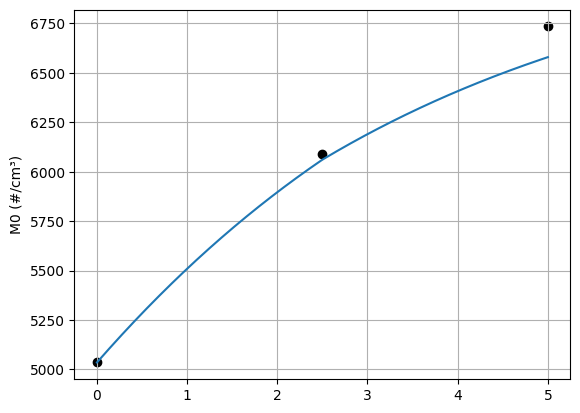

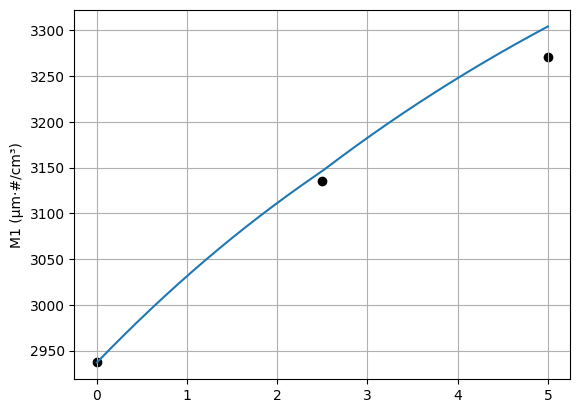

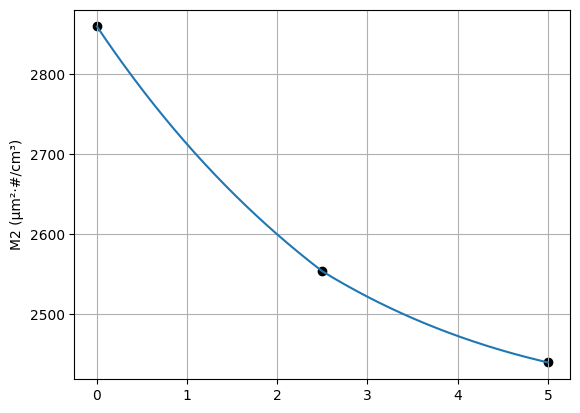

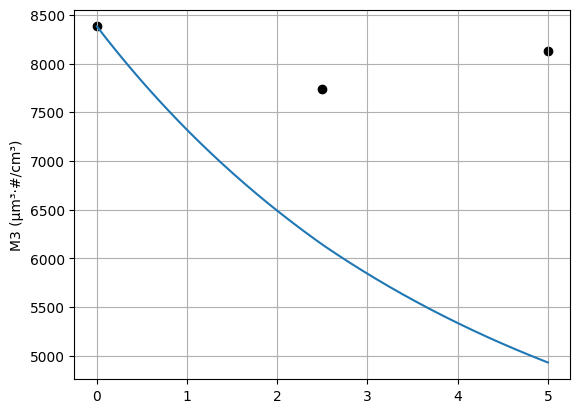

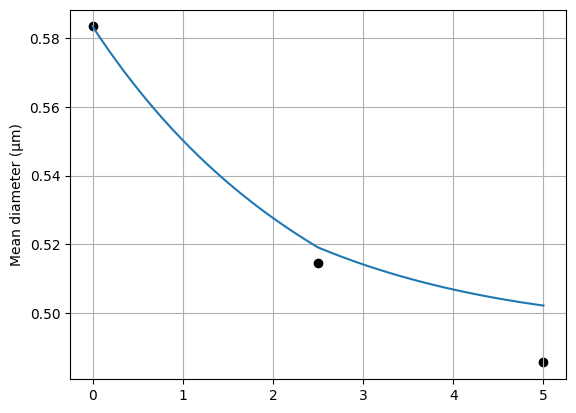

In [ ]:
# All models with physical sedimentation
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
# last modified January 11, 2026
# I changed the weights and the effective sedimentation height
# which significantly improved the predictions.
# This code splits an experimental interval 0-300 seconds for
# which we have expt M0-M3 into two intervals 0-150 sec and
# 150s- 300 sec. It seeks to find the J1, C1, J2, C2, K
# that best satisfy the expt moments at 0, 150, and 300 sec.
# J is the nucleation flux, C is the surface growth, and K is
# the Brownian agglomeration factor.
# In this model, the surface growth is independent of the diameter
#    dM0 = nuc0 + gr0 + co0 + sed0
#    dM1 = nuc1 + gr1 + co1 + sed1
#    dM2 = nuc2 + gr2 + co2 + sed2
#    dM3 = nuc3 + gr3 + co3 + sed3
# I use a weight factor array to help weight the matching to
# particular moments.
# weight vector for [M0, M1, M2, M3]. I get pretty good results
# with  w = np.array([3.0, 2.0, .1, 2.0])
# ============================================================
# SYSTEM GEOMETRY & PHYSICS
# ============================================================
rho_p = 1000      # kg/m3
rho_g = 1.2       # kg/m3
mu = 1.8e-5       # Pa s
g = 9.81          # m/s2
H = .3          # m  <-- effective chamber height

beta = (rho_p - rho_g) * g / (18 * mu * H)
beta *= 1e-12     # convert to s^-1 µm^-2

# ============================================================
# APS MEASUREMENTS
# ============================================================
t_data = np.array([0, 150, 300])
#The data below is 5.7 min to 10.033 min
#M_data = np.array([
#    [5344, 3883, 5575, 21578],
#    [4983, 3347, 4061, 13608],
#    [5035, 2937, 2860, 8382]
#])

#The data below is 10.033 min, 12.533 ,15.033 min
M_data = np.array([
    [5035, 2937, 2860, 8382],
    [6091.68, 3135.418, 2553.06, 7743.80],
    [6734.9, 3270.82, 2438.96, 8130.70]
])

din = 0.3  # µm

# ============================================================
# QMOM (2-node)
# ============================================================
#def qmom_nodes(M):
#    M0, M1, M2, M3 = M
#    mu_d = M1 / M0
#    var = max(M2 / M0 - mu_d**2, 1e-12)
#    std = np.sqrt(var)
#    return 0.5*M0, mu_d - std, 0.5*M0, mu_d + std

def qmom_nodes(M, eps_var=1e-18, Dmin=1e-30):
    """
    Two-node QMOM (Gaussian quadrature) reconstruction from moments M0..M3.

    Returns: (w1, D1, w2, D2) such that
        M_k ≈ w1*D1**k + w2*D2**k for k=0..3

    Notes:
      - Requires M0>0 and realizable moments; if variance is tiny, returns a
        degenerate 1-node quadrature: w1=M0, D1=mu1, w2=0, D2=mu1.
      - Clamps diameters to Dmin to avoid negative/zero nodes.
    """
    M0, M1, M2, M3 = M
    if M0 <= 0.0:
        return 0.0, Dmin, 0.0, Dmin

    # normalized moments
    mu1 = M1 / M0
    mu2 = M2 / M0
    mu3 = M3 / M0

    # variance-like term
    b1 = mu2 - mu1**2
    if b1 <= eps_var:
        D = max(mu1, Dmin)
        return float(M0), float(D), 0.0, float(D)

    a0 = mu1
    a1 = (mu3 - 2.0*mu1*mu2 + mu1**3) / b1

    # Solve for eigenvalues of 2x2 Jacobi matrix:
    # x^2 - (a0+a1)x + (a0*a1 - b1) = 0
    trace = a0 + a1
    det = a0*a1 - b1
    disc = trace*trace - 4.0*det
    disc = max(disc, 0.0)
    sqrt_disc = np.sqrt(disc)

    D1 = 0.5*(trace - sqrt_disc)
    D2 = 0.5*(trace + sqrt_disc)

    # enforce ordering and positivity
    D1 = max(D1, Dmin)
    D2 = max(D2, D1*(1.0 + 1e-12))

    # weights from M0 and M1
    # w1 + w2 = M0
    # w1*D1 + w2*D2 = M1
    denom = (D2 - D1)
    w1 = M0 * (D2 - mu1) / denom
    w2 = M0 * (mu1 - D1) / denom

    # small numerical cleanup
    if w1 < 0 and abs(w1) < 1e-12:
        w1 = 0.0
    if w2 < 0 and abs(w2) < 1e-12:
        w2 = 0.0

    return float(w1), float(D1), float(w2), float(D2)


# ============================================================
# MOMENT ODEs
# ============================================================
#def coag_source_qmom(k, K, w1, d1, w2, d2):
#    Ds = np.array([d1, d2], dtype=float)
#    Ws = np.array([w1, w2], dtype=float)
#    s = 0.0
#    for i in range(2):
#        for j in range(2):
#            di, dj = Ds[i], Ds[j]
#            wi, wj = Ws[i], Ws[j]
#            dp = np.cbrt(di**3 + dj**3)   # robust real cube root
#            s += (dp**k - di**k - dj**k) * wi * wj
#    return 0.5 * K * s

kB = 1.380649e-23  # J/K


# K_brownian_continuum_cm3s(di_um, dj_um, T=298.0, mu_g=1.8e-5):
def K_brownian_continuum(di, dj, T=298.0, mu_g=1.8e-5):
    di = max(di, 1e-30)
    dj = max(dj, 1e-30)
    return 1e6*(2.0 * kB * T / (3.0 * mu_g)) * ( (1.0/di + 1.0/dj) * (di + dj) )

#K=Kmult
def coag_source_qmom(k, K, w1, d1, w2, d2):
    T=298.0
    mu_g=1.8e-5
    Ds = np.array([d1, d2], dtype=float)
    Ws = np.array([w1, w2], dtype=float)
    s = 0.0
    for i in range(2):
        for j in range(2):
            di, dj = Ds[i], Ds[j]
            wi, wj = Ws[i], Ws[j]
            Kij = K * K_brownian_continuum(di, dj, T=T, mu_g=mu_g)
            dp = np.cbrt(di**3 + dj**3)
            s += Kij * (dp**k - di**k - dj**k) * wi * wj
    return 0.5 * s

#def moment_rhs(t, y, Jin, Cg, K):
#    M0, M1, M2, M3 = y
#    M0 = max(M0, 1e-9)
#
#    w1, d1, w2, d2 = qmom_nodes(y)
#    M4 = w1*d1**4 + w2*d2**4
#    M5 = w1*d1**5 + w2*d2**5
#
#    dM0 = Jin - 0.5*K*M0**2 - beta*M2
#    dM1 = Jin*din + Cg*M0 - beta*M3
#    dM2 = Jin*din**2 + 2*Cg*M1 + K*M1**2 - beta*M4
#    dM3 = Jin*din**3 + 3*Cg*M2 + 3*K*M1*M2 - beta*M5
#
#    return [dM0, dM1, dM2, dM3]

def moment_rhs(t, y, Jin, Cg, K):
    M0, M1, M2, M3 = y
    M0 = max(M0, 1e-12)

    w1, d1, w2, d2 = qmom_nodes(y)

    # higher moments for sedimentation sink
    M4 = w1*d1**4 + w2*d2**4
    M5 = w1*d1**5 + w2*d2**5

    # --- nucleation contributions ---
    nuc0 = Jin
    nuc1 = Jin * din
    nuc2 = Jin * din**2
    nuc3 = Jin * din**3

    # --- growth contributions (this assumes G_d is constant = Cg) ---
    # If your growth is actually m=-1 etc, change these accordingly.
    gr0 = 0.0
    gr1 = Cg * M0
    gr2 = 2.0 * Cg * M1
    gr3 = 3.0 * Cg * M2

    # --- coagulation contributions via QMOM closure ---
    co0 = coag_source_qmom(0, K, w1, d1, w2, d2)
    co1 = coag_source_qmom(1, K, w1, d1, w2, d2)
    co2 = coag_source_qmom(2, K, w1, d1, w2, d2)
    co3 = coag_source_qmom(3, K, w1, d1, w2, d2)

    # --- sedimentation sinks ---
    sed0 = -beta * M2
    sed1 = -beta * M3
    sed2 = -beta * M4
    sed3 = -beta * M5

    dM0 = nuc0 + gr0 + co0 + sed0
    dM1 = nuc1 + gr1 + co1 + sed1
    dM2 = nuc2 + gr2 + co2 + sed2
    dM3 = nuc3 + gr3 + co3 + sed3

    return [dM0, dM1, dM2, dM3]

def integrate_window(t0, t1, y0, Jin, Cg, K):
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
        (t0, t1),
        y0,
        t_eval=[t1],        # only need the endpoint
        method="BDF",
        rtol=1e-8,
        atol=1e-10
    )
    if (not sol.success) or np.any(~np.isfinite(sol.y)):
        return None
    return sol.y[:, -1]     # state at t1


def rel_residual(model, data):
    denom = np.maximum(np.abs(data), 1.0)
    return (model - data) / denom

def integrate_endpoint(t0, t1, y0, Jin, Cg, K):
    """
    Integrate moment ODEs from t0 to t1 and return the state at t1.
    Used for two-interval calibration.
    """
    sol = solve_ivp(
        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
        (t0, t1),
        y0,
        t_eval=[t1],          # only need endpoint
        method="BDF",         # stiff-safe
        rtol=1e-8,
        atol=1e-10
    )

    if (not sol.success) or np.any(~np.isfinite(sol.y)):
        return None

    return sol.y[:, -1]      # shape (4,)


def residuals_two_interval(params):
    J1, C1, J2, C2, K = params

    y150_model = integrate_endpoint(0.0, 150.0, M_data[0], J1, C1, K)
    if y150_model is None:
        return 1e6*np.ones(8)

    y300_model = integrate_endpoint(150.0, 300.0, y150_model, J2, C2, K)
    if y300_model is None:
        return 1e6*np.ones(8)

    y150_data = M_data[1]
    y300_data = M_data[2]

    r150 = (y150_model - y150_data) / np.maximum(np.abs(y150_data), 1.0)
    r300 = (y300_model - y300_data) / np.maximum(np.abs(y300_data), 1.0)

    # weight vector for [M0, M1, M2, M3]
    #w = np.array([3.0, 2.0, .1, 2.0])
    w = np.array([1.0, 1.0, 60., 1.0])

    r150 *= w
    r300 *= w

    return np.hstack([r150, r300])


# def residuals_two_interval(params):
#     J1, C1, J2, C2, K = params

#     y0 = M_data[0]               # state at t=0
#     y150_target = M_data[1]      # data at t=150
#     y300_target = M_data[2]      # data at t=300

#     # integrate 0 -> 150 using window 1 params
#     y150_model = integrate_window(0.0, 150.0, y0, J1, C1, K)
#     if y150_model is None:
#         return 1e6 * np.ones(8)  # 4 moments at 150 + 4 moments at 300

#     # integrate 150 -> 300 using window 2 params, starting from model state at 150
#     y300_model = integrate_window(150.0, 300.0, y150_model, J2, C2, K)
#     if y300_model is None:
#         return 1e6 * np.ones(8)

#     r150 = rel_residual(y150_model, y150_target)
#     r300 = rel_residual(y300_model, y300_target)

#     return np.hstack([r150, r300])

# ============================================================
# CALIBRATION
# ============================================================
#def residuals(params):
#    Jin, Cg, K = params
#    sol = solve_ivp(
#        lambda t, y: moment_rhs(t, y, Jin, Cg, K),
#        [0, 300],
#        M_data[0],
#        t_eval=t_data
#    )
#    return (sol.y.T - M_data).ravel()
#def residuals(params):
#    Jin, Cg, K = params

#    sol = solve_ivp(
    #     lambda t, y: moment_rhs(t, y, Jin, Cg, K),
    #     (t_data[0], t_data[-1]),
    #     M_data[0],
    #     t_eval=t_data,
    #     method="BDF",        # better if stiff
    #     rtol=1e-8,
    #     atol=1e-10
    # )

    # if (not sol.success) or np.any(~np.isfinite(sol.y)):
    #     # punish failed integrations so optimizer moves away
    #     return 1e6 * np.ones(M_data.size)

    # model = sol.y.T

    # # Relative residuals (recommended)
    # denom = np.maximum(np.abs(M_data), 1.0)
    # r = (model - M_data) / denom
    # return r.ravel()

x0 = [10, 0.004,   10, 0.004,   1.0]      # [J1,C1,J2,C2,K]
lb = [0,  0.0,     0,  0.0,     0.0]
ub = [50, 0.02,    50, 0.02,    1e3]      # K is a multiplier in your Brownian kernel

res = least_squares(
    residuals_two_interval,
    x0,
    bounds=(lb, ub)
)

J1, C1, J2, C2, K = res.x

print("\nCALIBRATED PARAMETERS (two-interval)")
print(f"Window 0-150: J1={J1:.3f} #/cm3/s, C1={C1:.6f} µm/s")
print(f"Window 150-300: J2={J2:.3f} #/cm3/s, C2={C2:.6f} µm/s")
print(f"K multiplier={K:.3e} (Brownian kernel scale)")
print(f"beta = {beta:.2e} s^-1 µm^-2")


# res = least_squares(
#     residuals,
#     [10, 0.004, 1e-10],
#     bounds=([0, 0, 0], [50, 0.02, 1e-8])
# )

# Jin, Cg, K = res.x

# print("\nCALIBRATED PARAMETERS")
# print(f"J_in = {Jin:.2f} #/cm3/s")
# print(f"C_g  = {Cg:.4f} µm/s")
# print(f"K    = {K:.2e} cm3/s")
# print(f"beta = {beta:.2e} s^-1 µm^-2 (from H)")

# ============================================================
# FULL SOLUTION
# ============================================================
# t = np.linspace(0, 5*60, 400)
# sol = solve_ivp(
#     lambda t, y: moment_rhs(t, y, Jin, Cg, K),
#     [0, 300],
#     M_data[0],
#     t_eval=t
# )

# M0, M1, M2, M3 = sol.y
# mean_d = M1 / M0
t1 = np.linspace(0, 150, 200)
sol1 = solve_ivp(
    lambda t, y: moment_rhs(t, y, J1, C1, K),
    (0, 150),
    M_data[0],
    t_eval=t1,
    method="BDF",
    rtol=1e-8,
    atol=1e-10
)
y150_model = sol1.y[:, -1]

t2 = np.linspace(150, 300, 200)
sol2 = solve_ivp(
    lambda t, y: moment_rhs(t, y, J2, C2, K),
    (150, 300),
    y150_model,
    t_eval=t2,
    method="BDF",
    rtol=1e-8,
    atol=1e-10
)

# stitch
t = np.hstack([sol1.t, sol2.t])
Y = np.hstack([sol1.y, sol2.y])
M0, M1, M2, M3 = Y
mean_d = M1 / M0

# # Mode estimate
# mode = np.zeros_like(mean_d)
# for i in range(len(t)):
#     w1, d1, w2, d2 = qmom_nodes([M0[i], M1[i], M2[i], M3[i]])
#     mode[i] = d1 if w1 > w2 else d2

# # ============================================================
# # PLOTS
# # ============================================================
# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,0], c='k')
# plt.ylabel("Number (#/cm³)")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,2], c='k')
# plt.ylabel("M2")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, M0)
# plt.scatter(t_data/60, M_data[:,3], c='k')
# plt.ylabel("M3")
# plt.xlabel("Time (min)")
# plt.grid()

# plt.figure()
# plt.plot(t/60, mean_d, label="Mean")
# #plt.plot(t/60, mode, '--', label="Mode")
# plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
# plt.ylabel("Diameter (µm)")
# plt.xlabel("Time (min)")
# plt.legend()
# plt.grid()
# plt.show()
plt.figure()
plt.plot(t/60, M0)
plt.scatter(t_data/60, M_data[:,0], c='k')
plt.ylabel("M0 (#/cm³)")
plt.grid()

plt.figure()
plt.plot(t/60, M1)
plt.scatter(t_data/60, M_data[:,1], c='k')
plt.ylabel("M1 (µm·#/cm³)")
plt.grid()

plt.figure()
plt.plot(t/60, M2)
plt.scatter(t_data/60, M_data[:,2], c='k')
plt.ylabel("M2 (µm²·#/cm³)")
plt.grid()

plt.figure()
plt.plot(t/60, M3)
plt.scatter(t_data/60, M_data[:,3], c='k')
plt.ylabel("M3 (µm³·#/cm³)")
plt.grid()

plt.figure()
plt.plot(t/60, mean_d)
plt.scatter(t_data/60, M_data[:,1]/M_data[:,0], c='k')
plt.ylabel("Mean diameter (µm)")
plt.grid()
plt.show()

#np.savetxt('data.csv', (t/60, M0, mean_d), delimiter=',')
